# In this notebook I will briefly explore the Arrhythmia dataset via visualization, make a few educated guesses at important features in determining arrhythmia.

# The arrhythmia dataset contains 16 labels - 15 of which indicate an arrhythmia - while the remaining label indicates a normal ECG. I am certainly no cardiologist, and for the sake of binary classification this dataset lends itself well to simplifying a multi-label or multi-class problem. 

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
sns.set()

# import the dataset .csv as DataFrame
arrhythmia_df_raw = pd.read_csv('arrhythmia_with_column_names.csv')
print(arrhythmia_df_raw.shape)

# in the case of constant features, remove columns whose values aren't unique
arrhythmia_df = arrhythmia_df_raw.loc[:, arrhythmia_df_raw.apply(pd.Series.nunique) != 1]
print(arrhythmia_df.shape)

# from reading the authors' documentation, missing values are indicated by '?' - let's replace them now
arrhythmia_df.replace(to_replace='?', value=np.nan, inplace=True)
features_df = arrhythmia_df.drop(columns=['Class'], inplace=False)
features_imputed = SimpleImputer(missing_values=np.nan, strategy='median').fit_transform(features_df)

arrhythmia = pd.concat([features_df, arrhythmia_df['Class']], axis=1)
arrhythmia.head()

(450, 280)
(450, 263)


,Age,Sex,Height,Weight,QRS_Dur,P-R_Int,Q-T_Int,T_Int,P_Int,QRS,...,V6270,V6271,V6272,V6273,V6274,V6276,V6277,V6278,V6279,Class
0,54,0,172,95,138,163,386,185,102,96,...,0.9,0.0,9.5,-2.4,0.0,0.3,3.4,12.3,49.0,10
1,55,0,175,94,100,202,380,179,143,28,...,0.1,0.0,12.2,-2.2,0.0,0.4,2.6,34.6,61.6,1
2,75,0,190,80,88,181,360,177,103,-16,...,-0.4,0.0,13.1,-3.6,0.0,-0.1,3.9,25.4,62.8,7
3,13,0,169,51,100,167,321,174,91,107,...,0.0,-0.6,12.2,-2.8,0.0,0.9,2.2,13.5,31.1,14
4,40,1,160,52,77,129,377,133,77,77,...,-0.4,0.0,6.5,0.0,0.0,0.4,1.0,14.3,20.5,1


My personal preference in plotting categorical/nominal variables is using strings instead of numerical indicators. This means converting the [0, 1] value range for the 'Sex' feature to ['Male', 'Female']. To simplify the multiple labels/class codes in this dataset, we can define 'Class' == 1 as 'No Arrhythmia' and 'Class' != 1 as 'Arrhythmia'.

In [2]:
# before proceeding to exploratory visualizations, let's make some variables categorical
class_binary_list = []
for class_code in arrhythmia['Class'].tolist():
    class_binary_list.append('No Arrhythmia' if class_code == 1 else 'Arrhythmia')
sex_categorical_list = []
for sex_code in arrhythmia['Sex'].tolist():
    sex_categorical_list.append('Male' if sex_code == 0 else 'Female')
arrhythmia['Sex_categorical'] = sex_categorical_list
arrhythmia['Class_binary'] = class_binary_list

In [3]:
# let's begin exploring relationships between amongst the data
# initialize a dictionary for easier argument entry into plotting
pair_plot_dict = {'data': arrhythmia, 'hue': 'Class_binary', 'palette': {'No Arrhythmia': 'b', 'Arrhythmia': 'r'},
                  'diag_sharey': False, 'corner': True, 'dropna': True}


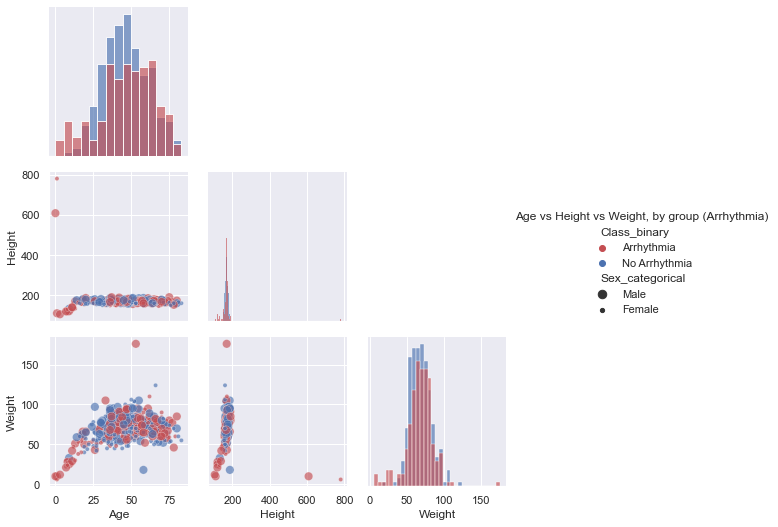

In [4]:
fig_pair_demographics = sns.PairGrid(vars=['Age', 'Height', 'Weight'], **pair_plot_dict)
fig_pair_demographics.map_diag(sns.histplot, alpha=0.65)
# we can scale the marker size in scatter plots by the 'Sex_categorical' feature
fig_pair_demographics.map_offdiag(sns.scatterplot, alpha=0.65, size=arrhythmia['Sex_categorical'])
fig_pair_demographics.add_legend(title='Age vs Height vs Weight, by group (Arrhythmia)', adjust_subtitles=True)

In [5]:
# let's remove the outliers' data identified by height and weight
arrhythmia.drop(arrhythmia[(arrhythmia['Height'] > 600) | (arrhythmia['Weight'] > 170)].index, inplace=True)
print(arrhythmia.shape)

(447, 265)


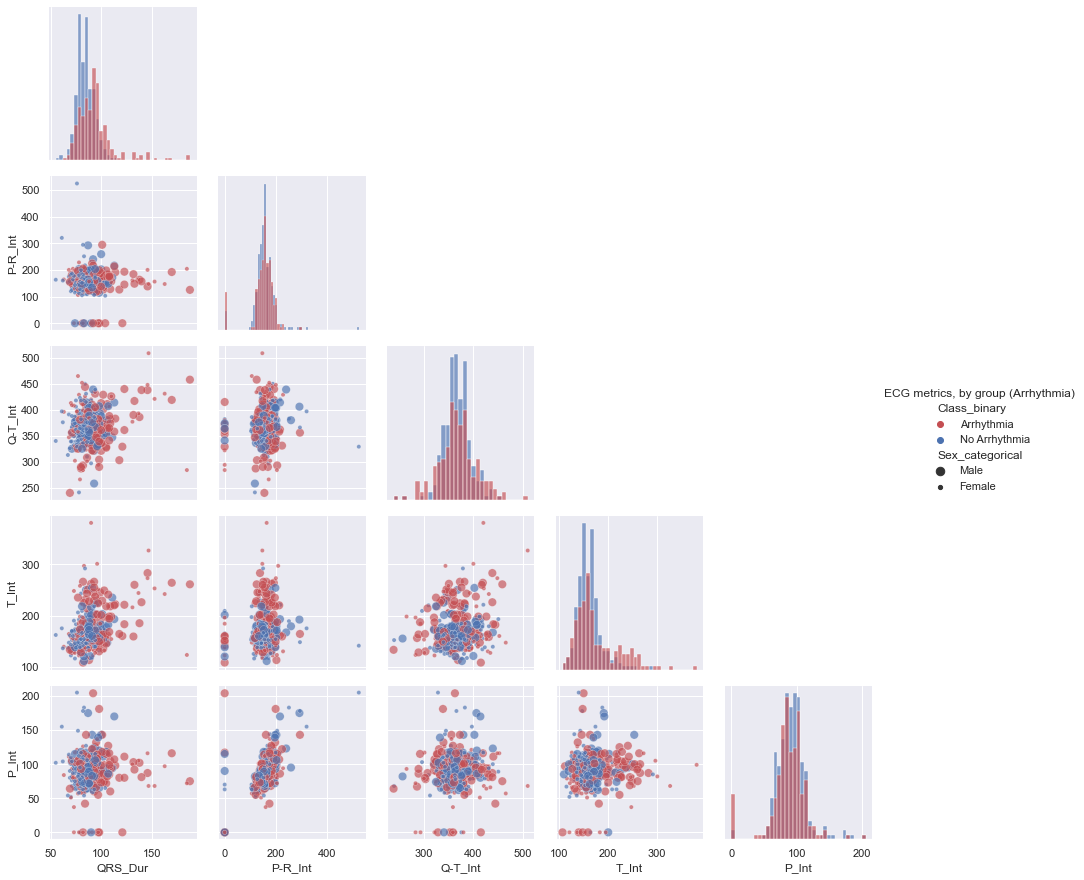

In [6]:
fig_pair_metrics = sns.PairGrid(data=arrhythmia, vars=['QRS_Dur', 'P-R_Int', 'Q-T_Int', 'T_Int', 'P_Int'],
                 hue='Class_binary', palette={'No Arrhythmia': 'b', 'Arrhythmia': 'r'}, diag_sharey=False, corner=True, dropna=True)
fig_pair_metrics.map_diag(sns.histplot, alpha=0.65) # plot a histogram when the pairs of variables are the same
fig_pair_metrics.map_offdiag(sns.scatterplot, alpha=0.65, size=arrhythmia['Sex_categorical'])
fig_pair_metrics.add_legend(title='ECG metrics, by group (Arrhythmia)', adjust_subtitles=True)

Immediately, it looks like there are separable relationships between the QRS duration and the P-R interval, Q-T interval, T interval, as well as the P interval. Additionally, the distributions of each group's QRS duration, T interval, Q-T interval, and P interval look promising.

In [7]:
# let's compare the arrythmia group vs no-arrhythmia group
from scipy.stats import ranksums
# we can use the Wilcoxon ranksum to discern whether the groups' measurements are from the same distribution
from pingouin import compute_effsize
# we can use cohen's d effect size to quantify how large of an effect exists
for feature in ['QRS_Dur', 'T_Int', 'Q-T_Int', 'P_Int']:
    arrhythmia_group = arrhythmia[arrhythmia['Class_binary'] == 'Arrhythmia'][feature]
    no_arrhythmia_group = arrhythmia[arrhythmia['Class_binary'] == 'No Arrhythmia'][feature]
    tstat, p = ranksums(arrhythmia_group, no_arrhythmia_group)
    effsize = compute_effsize(arrhythmia_group, no_arrhythmia_group, eftype='cohen')
    msg = f"Groups comparison for {feature}: t-stat = {tstat.round(2)}, p = {p.round(12)}, cohen's d = {effsize.round(2)}\n"
    print(msg)

Groups comparison for QRS_Dur: t-stat = 6.82, p = 9e-12, cohen's d = 0.7

Groups comparison for T_Int: t-stat = 2.68, p = 0.007271385893, cohen's d = 0.45

Groups comparison for Q-T_Int: t-stat = 0.33, p = 0.738378238309, cohen's d = 0.04

Groups comparison for P_Int: t-stat = -0.89, p = 0.375346839092, cohen's d = -0.19



There is a large and medium effect between groups for the QRS duration and T interval features, respectively. We can also conclude the medians of these groups' feature distributions also differ significantly, as evidenced by the p-values. These features look quite promising in discerning between Arrhythmia/No Arrhythmia.

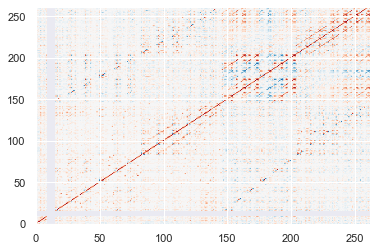

In [8]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# I want to look into the features a bit more deeply, specifically how they are correlated...
# we can plot a covariance matrix of the scaled data to give us a feel - basically a correlogram
X = arrhythmia.drop(columns=['Class', 'Class_binary', 'Sex_categorical'], inplace=False)
plt.imshow(np.cov(StandardScaler().fit_transform(X), rowvar=False), aspect='auto', vmin=-1, vmax=1, cmap='RdBu_r', origin='lower')


In [9]:
# save the formatted, cleaned DataFrame for future use
arrhythmia.to_csv('1_data_exploration_arrhythmia.csv', index=False)